# Data Exploration

## Experiment Setup

In [1]:
# Setting up execution path
import os

print(f"Current working directory: {os.path.basename(os.getcwd())}")

# Change to root directory
os.chdir("../")
print(f"Current working directory (Changed): {os.path.basename(os.getcwd())}")

Current working directory: notebooks
Current working directory (Changed): SMS-Spam-Detector


In [2]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# module setup
%matplotlib inline
pd.options.display.precision = 3
warnings.filterwarnings("ignore")

In [3]:
# Additional imports
import nltk

In [3]:
df = pd.read_csv(
    "data/raw/SMSSpamCollection",
    sep="\t",
    header=None,
    names=["label", "message"],
    encoding="utf-8",
).reindex(["message", "label"], axis="columns")
df

,message,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam
5568,Will ü b going to esplanade fr home?,ham
5569,"Pity, * was in mood for that. So...any other s...",ham
5570,The guy did some bitching but I acted like i'd...,ham


In [17]:
df["label"].value_counts()["spam"]

747

In [6]:
df["label"].value_counts(normalize=True)

label
ham     0.866
spam    0.134
Name: proportion, dtype: float64

The dataset is imbalanced since we can clearly see that only 13% of the data belongs to
class `spam` whereas 86% of the data belongs to `ham` class.

To make the dataset balanced, we gonna randomly choose just `747` rows of `ham` class and
create a balanced dataset for further analysis and training the classification model

In [7]:
# filtering and creating individual dataset
ham_msgs = df[df["label"] == "ham"].sample(n=747, random_state=42)
spam_msgs = df[df["label"] == "spam"]

# concat and randomize class appearance, so that, model don't see an order
sms_df = (
    pd.concat([ham_msgs, spam_msgs], ignore_index=True)
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

# final balanced class dataset
sms_df

,message,label
0,"URGENT, IMPORTANT INFORMATION FOR O2 USER. TOD...",spam
1,Panasonic & BluetoothHdset FREE. Nokia FREE. M...,spam
2,Do you want a new Video handset? 750 any time ...,spam
3,Hi if ur lookin 4 saucy daytime fun wiv busty ...,spam
4,09066362231 URGENT! Your mobile No 07xxxxxxxxx...,spam
...,...,...
1489,December only! Had your mobile 11mths+? You ar...,spam
1490,Loans for any purpose even if you have Bad Cre...,spam
1491,You have an important customer service announc...,spam
1492,URGENT! Your Mobile number has been awarded wi...,spam


In [32]:
def balance_dataframe(df, class_names, label_column):
    class_counts = []
    for cls in class_names:
        n_rows = df[label_column].value_counts()[cls]
        class_counts.append((cls, n_rows))

    min_class = min(class_counts, key=lambda x: x[1])
    balanced_n = min_class[1]

    class_dfs_list = []
    for cls in class_names:
        part_df = df[df[label_column] == cls].sample(n=balanced_n, random_state=42)
        class_dfs_list.append(part_df)

    balanced_df = (
        pd.concat(class_dfs_list, ignore_index=True)
        .sample(frac=1, random_state=42)
        .reset_index(drop=True)
    )

    return balanced_df

In [34]:
balanced_df = balance_dataframe(df, ["spam", "ham"], "label")
balanced_df.head(10)

,message,label
0,The evo. I just had to download flash. Jealous?,ham
1,Hi Dear Call me its urgnt. I don't know whats ...,ham
2,Full heat pa:-) i have applyed oil pa.,ham
3,Gokila is talking with you aha:),ham
4,"Dude u knw also telugu..thts gud..k, gud nyt..",ham
5,"URGENT! Your mobile was awarded a £1,500 Bonus...",spam
6,Your unique user ID is 1172. For removal send ...,spam
7,For ur chance to win £250 cash every wk TXT: P...,spam
8,Back 2 work 2morro half term over! Can U C me ...,spam
9,Free video camera phones with Half Price line ...,spam


In [36]:
balanced_df["label"].value_counts()

label
ham     747
spam    747
Name: count, dtype: int64

In [8]:
sms_df["label"].value_counts()

label
spam    747
ham     747
Name: count, dtype: int64

## Data Analysis

In [9]:
sms_df.describe()

,message,label
count,1494,1494
unique,1378,2
top,"Sorry, I'll call later",spam
freq,8,747


In [10]:
sms_df.groupby("label").describe().transpose()

label                              ham  \
message count                      747   
        unique                     725   
        top     Sorry, I'll call later   
        freq                         8   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

In [11]:
sms_df["msg_length"] = sms_df["message"].str.len()

sms_df.head()

,message,label,msg_length
0,"URGENT, IMPORTANT INFORMATION FOR O2 USER. TOD...",spam,163
1,Panasonic & BluetoothHdset FREE. Nokia FREE. M...,spam,150
2,Do you want a new Video handset? 750 any time ...,spam,135
3,Hi if ur lookin 4 saucy daytime fun wiv busty ...,spam,159
4,09066362231 URGENT! Your mobile No 07xxxxxxxxx...,spam,152


<Axes: ylabel='Frequency'>

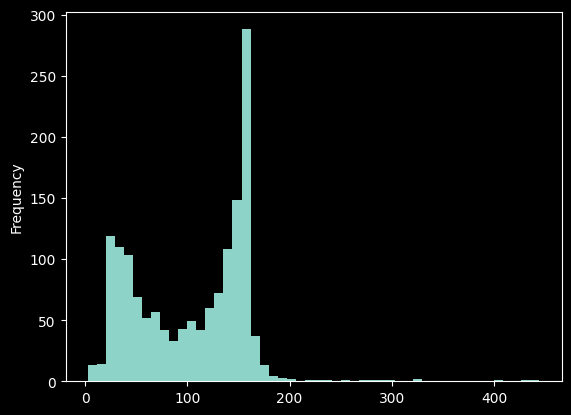

In [12]:
sms_df["msg_length"].plot.hist(bins=50)
# seems like a bimodal distribution

In [13]:
sms_df["msg_length"].describe()

count    1494.000
mean      104.049
std        54.972
min         3.000
25%        49.000
50%       118.000
75%       152.000
max       444.000
Name: msg_length, dtype: float64

In [14]:
longest_sms = sms_df[sms_df["msg_length"] == 444]["message"].iloc[0]
print(longest_sms)

Solve d Case : A Man Was Found Murdered On  &lt;DECIMAL&gt; . &lt;#&gt;  AfterNoon. 1,His wife called Police. 2,Police questioned everyone. 3,Wife: Sir,I was sleeping, when the murder took place. 4.Cook: I was cooking. 5.Gardener: I was picking vegetables. 6.House-Maid: I went 2 d post office. 7.Children: We went 2 play. 8.Neighbour: We went 2 a marriage. Police arrested d murderer Immediately. Who's It? Reply With Reason, If U r Brilliant.


array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

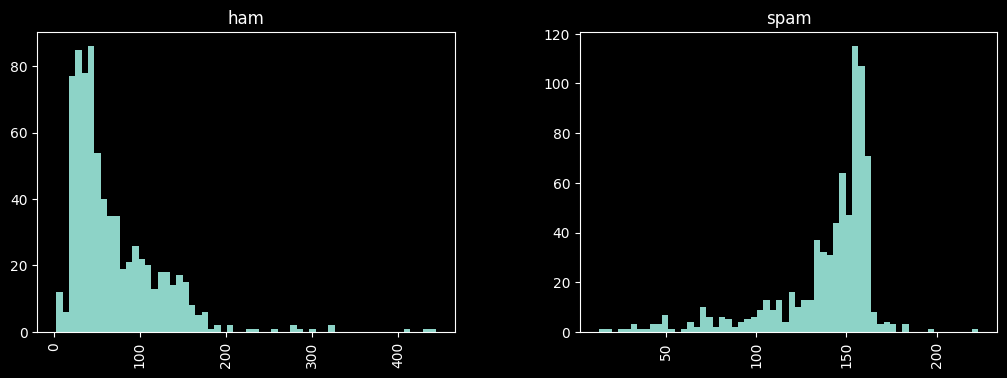

In [15]:
sms_df.hist(column="msg_length", by="label", bins=60, figsize=(12, 4))
# most spam messages are longer (have more characters)  than ham messages
# message length seems like a differentiator to detect spam/ham message

### Function for Creating Tokens

In [16]:
import string

In [17]:
punctuations = string.punctuation
punctuations

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [18]:
sample_msg = "sample msg! notice: it has punc'tuation> $45"
nopunc_word_list = [char for char in sample_msg if char not in string.punctuation]
nopunc_msg = "".join(nopunc_word_list)
print(nopunc_msg)

sample msg notice it has punctuation 45


In [19]:
from nltk.corpus import stopwords

In [20]:
en_stopwords = stopwords.words("english")
print(len(en_stopwords))

179


In [21]:
en_stopwords[:5]

['i', 'me', 'my', 'myself', 'we']

In [22]:
clean_msg = [word for word in nopunc_msg.split() if word.lower() not in en_stopwords]
print(" ".join(clean_msg))

sample msg notice punctuation 45


In [23]:
clean_msg

['sample', 'msg', 'notice', 'punctuation', '45']

since we have sms text messages which are very small and words like "dun" for "done",
"u" for "you" and more such short-hands, stemming isn't gonna work so great for this dataset, or,
fair to say, won't have any significant impact on it. so, we gonna skip it

### Create function to fetch tokens

In [24]:
import string
from nltk.corpus import stopwords

def get_tokens(msg_str: str) -> list:
    en_stopwords = stopwords.words("english")
    
    nopunc_words = "".join([char for char in msg_str if char not in string.punctuation]).split()
    tokens = [word for word in nopunc_words if word.lower() not in en_stopwords]
    
    return tokens

In [25]:
tokens = get_tokens(sample_msg)
tokens

['sample', 'msg', 'notice', 'punctuation', '45']

### Apply function on dataframe

In [26]:
sms_df["tokens"] = sms_df["message"].apply(get_tokens)
sms_df.head(10)

,message,label,msg_length,tokens
0,"URGENT, IMPORTANT INFORMATION FOR O2 USER. TOD...",spam,163,"[URGENT, IMPORTANT, INFORMATION, O2, USER, TOD..."
1,Panasonic & BluetoothHdset FREE. Nokia FREE. M...,spam,150,"[Panasonic, BluetoothHdset, FREE, Nokia, FREE,..."
2,Do you want a new Video handset? 750 any time ...,spam,135,"[want, new, Video, handset, 750, time, network..."
3,Hi if ur lookin 4 saucy daytime fun wiv busty ...,spam,159,"[Hi, ur, lookin, 4, saucy, daytime, fun, wiv, ..."
4,09066362231 URGENT! Your mobile No 07xxxxxxxxx...,spam,152,"[09066362231, URGENT, mobile, 07xxxxxxxxx, £20..."
5,Will do. Was exhausted on train this morning. ...,ham,87,"[exhausted, train, morning, much, wine, pie, s..."
6,Oh Howda gud gud.. Mathe en samachara chikku:-),ham,47,"[Oh, Howda, gud, gud, Mathe, en, samachara, ch..."
7,"Dear Hero,i am leaving to qatar tonite for an ...",ham,108,"[Dear, Heroi, leaving, qatar, tonite, apt, opp..."
8,Great! How is the office today?,ham,31,"[Great, office, today]"
9,Oooh bed ridden ey? What are YOU thinking of?,ham,45,"[Oooh, bed, ridden, ey, thinking]"


In [27]:
##

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

In [29]:
bow_transformer = CountVectorizer(analyzer=get_tokens)
bow_transformer

CountVectorizer(analyzer=<function get_tokens at 0x00000144F597A170>)

In [30]:
bow_transformer.fit(sms_df["message"])

CountVectorizer(analyzer=<function get_tokens at 0x00000144F597A170>)

In [31]:
bow_transformer.vocabulary_

{'URGENT': 2408,
 'IMPORTANT': 1481,
 'INFORMATION': 1487,
 'O2': 1848,
 'USER': 2410,
 'TODAY': 2303,
 'LUCKY': 1603,
 'DAY': 1106,
 '2': 397,
 'FIND': 1246,
 'LOG': 1591,
 'ONTO': 1856,
 'HTTPWWWURAWINNERCOM': 1400,
 'FANTASTIC': 1236,
 'SURPRISE': 2136,
 'AWAITING': 807,
 'Panasonic': 1934,
 'BluetoothHdset': 942,
 'FREE': 1254,
 'Nokia': 1830,
 'Motorola': 1760,
 'DoubleMins': 1169,
 'DoubleTxt': 1170,
 'Orange': 1879,
 'contract': 3128,
 'Call': 1022,
 'MobileUpd8': 1745,
 '08000839402': 52,
 'call': 2913,
 '2optout': 477,
 'want': 5280,
 'new': 4226,
 'Video': 2452,
 'handset': 3683,
 '750': 660,
 'time': 5085,
 'network': 4221,
 'mins': 4137,
 'UNLIMITED': 2404,
 'TEXT': 2291,
 'Camcorder': 1032,
 'Reply': 2051,
 '08000930705': 53,
 'del': 3228,
 'Sat': 2150,
 'Hi': 1439,
 'ur': 5208,
 'lookin': 3999,
 '4': 536,
 'saucy': 4705,
 'daytime': 3209,
 'fun': 3570,
 'wiv': 5356,
 'busty': 2897,
 'married': 4066,
 'woman': 5366,
 'free': 3544,
 'next': 4230,
 'week': 5307,
 'Chat': 105

In [32]:
len(bow_transformer.vocabulary_)

5560

In [33]:
sparse_mat_bow = bow_transformer.transform(sms_df["message"])

In [34]:
sparse_mat_bow.shape

(1494, 5560)

In [35]:
sparse_mat_bow.nnz

17976

In [36]:
sparcity = 100.0 * (sparse_mat_bow.nnz/(sparse_mat_bow.shape[0] * sparse_mat_bow.shape[1]))
sparcity

0.21640518910173065

In [37]:
from sklearn.feature_extraction.text import TfidfTransformer

In [38]:
tfidf_transformer = TfidfTransformer().fit(sparse_mat_bow)
tfidf_transformer

TfidfTransformer()

In [39]:
sparse_mat_tfidf = tfidf_transformer.transform(sparse_mat_bow)
sparse_mat_tfidf

<1494x5560 sparse matrix of type '<class 'numpy.float64'>'
	with 17976 stored elements in Compressed Sparse Row format>

In [40]:
tfidf_transformer.idf_[bow_transformer.vocabulary_["university"]]

7.616734305264841

In [41]:
sparse_df = pd.DataFrame(sparse_mat_tfidf.toarray(), columns=bow_transformer.get_feature_names_out())
sparse_df

,0,008704050406,0089my,0121,01223585236,01223585334,02,020603,0207,02070836089,...,£800,£900,£s,Ü,ü,üll,–,“,“Harry,…
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.269,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
sparse_df.min().min(), sparse_df.max().max()

(0.0, 1.0)

In [43]:
from sklearn.preprocessing import MinMaxScaler

In [44]:
# Step 1: Scale the "length" field using MinMaxScaler
scaler = MinMaxScaler()
length_scaled = scaler.fit_transform(sms_df[["msg_length"]])


length_scaled



array([[0.36281179],
       [0.33333333],
       [0.29931973],
       ...,
       [0.21768707],
       [0.31746032],
       [0.27437642]])

In [45]:
length_scaled.min(), length_scaled.max()

(0.0, 1.0)

In [46]:
# Step 2: Concatenate the sparse matrix representing TF-IDF features and the scaled "length" array
concatenated_matrix = np.hstack([sparse_mat_tfidf.toarray(), length_scaled])

concatenated_matrix.shape

(1494, 5561)

In [47]:
type(concatenated_matrix), type(sparse_mat_tfidf)

(numpy.ndarray, scipy.sparse._csr.csr_matrix)

In [48]:
# Assuming you have labels for your data
labels = np.array(sms_df["label"])
labels, type(labels)

(array(['spam', 'spam', 'spam', ..., 'spam', 'spam', 'spam'], dtype=object),
 numpy.ndarray)

In [49]:
from sklearn.naive_bayes import MultinomialNB

In [50]:
nb_classifier = MultinomialNB()
nb_classifier.fit(concatenated_matrix, labels)

MultinomialNB()

## Creating Pipeline

In [51]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from scipy.sparse import csr_matrix
from nltk.corpus import stopwords
import numpy as np
import string

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [81]:
def get_str_tokens(msg_str: str) -> list:
    en_stopwords = stopwords.words("english")
    
    nopunc_words = "".join([char for char in msg_str if char not in string.punctuation]).split()
    tokens = [word for word in nopunc_words if word.lower() not in en_stopwords]
    tokens_str = " ".join(tokens)
    return tokens_str

def get_tokens(messages):
    return np.array([get_str_tokens(message) for message in messages])
def get_length(messages):
    return np.array([len(message) for message in messages]).reshape(-1, 1)

tfidf_pipeline = Pipeline([
    ('tokenization', FunctionTransformer(get_tokens, validate=False)),
    ('bag_of_words', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])

# Pipeline for scaling the length feature
length_pipeline = Pipeline([
    ('length_extractor', FunctionTransformer(get_length, validate=False)),
    ('min_max_scaler', MinMaxScaler()),
])

# Define ColumnTransformer
column_transformer = ColumnTransformer([
    ('tfidf_transform', tfidf_pipeline, 'message'),
    ('length_transform', length_pipeline, 'message')
])

In [82]:
norm = column_transformer.fit_transform(sms_df)

In [83]:
norm.shape

(1494, 4659)

In [65]:
pd.DataFrame(norm.toarray())

,0,1,2,3,4,5,6,7,8,9,...,4649,4650,4651,4652,4653,4654,4655,4656,4657,4658
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.363
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.299
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.354
4,0.0,0.0,0.0,0.0,0.0,0.0,0.282,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.351
1490,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.234
1491,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.218
1492,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.317


Pipeline(steps=[('tokenization',
                 FunctionTransformer(func=<function get_tokens at 0x00000144FA5C2830>)),
                ('bag_of_words', CountVectorizer()),
                ('tfidf', TfidfTransformer())])

In [69]:
tfidf_transformer = column_transformer.named_transformers_['tfidf_transform']

In [70]:
tfidf_transformer

Pipeline(steps=[('tokenization',
                 FunctionTransformer(func=<function get_tokens at 0x00000144FA5C2830>)),
                ('bag_of_words', CountVectorizer()),
                ('tfidf', TfidfTransformer())])

In [73]:
preds = nb_classifier.predict(concatenated_matrix)
preds

array(['spam', 'spam', 'spam', ..., 'spam', 'spam', 'ham'], dtype='<U4')

In [72]:
from sklearn.metrics import classification_report

In [74]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       747
        spam       0.99      0.98      0.99       747

    accuracy                           0.99      1494
   macro avg       0.99      0.99      0.99      1494
weighted avg       0.99      0.99      0.99      1494



In [75]:
nb_classifier2 = MultinomialNB()
nb_classifier2.fit(norm, labels)

MultinomialNB()

In [76]:
preds2 = nb_classifier.predict(concatenated_matrix)
preds2

array(['spam', 'spam', 'spam', ..., 'spam', 'spam', 'ham'], dtype='<U4')

In [77]:
print(classification_report(labels, preds2))

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       747
        spam       0.99      0.98      0.99       747

    accuracy                           0.99      1494
   macro avg       0.99      0.99      0.99      1494
weighted avg       0.99      0.99      0.99      1494

